# Divide data into phases

In [2]:
import json
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# from transformers.tokenization_bert import BasicTokenizer
import torch
from pycocotools.coco import COCO
import spacy 
import random

/dvmm-filer2/users/hammad/miniconda3/envs/gaila_v2/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.modeling.language_backbone.transformers import BERT

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
ann_file = '../datasets/coco/annotations/captions_train2017.json'
with open(ann_file, 'r') as fin:
    coco_train_anno_all = json.load(fin)

In [6]:
len(coco_train_anno_all['annotations'])

591753

In [7]:
print(coco_train_anno_all['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [8]:
count=1
id=coco_train_anno_all['annotations'][0]['image_id']
for item in coco_train_anno_all['annotations'][1:]:
    if item['image_id'] == id:
        count += 1
print(count)

5


In [9]:
random.seed(1)

reduce_to_percent = 1.0
total_annotations = coco_train_anno_all['annotations']
total_no_annotations = len(total_annotations)

sz = int(total_no_annotations * reduce_to_percent)
sampled_ids = random.sample(range(total_no_annotations), k=sz)
annotations = (np.array(total_annotations)[sampled_ids]).tolist()

In [10]:
len(annotations)

591753

# Getting Stats

In [11]:
# Counts number of examples for each noun 
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_tp_no_distr_stats(max_noun_no, tp):
    
    noun_distr_per_noun_no = {}
    ex_count_per_noun_no = {}
    img_caps_per_noun_no = {}
    
    for i in range(1,max_noun_no+1):
        noun_distr_per_noun_no[i] = {}
        ex_count_per_noun_no[i] = 0 
        img_caps_per_noun_no[i] = []
        
    noun_distr_per_noun_no['Rest'] = {}
    ex_count_per_noun_no['Rest'] = 0 
    img_caps_per_noun_no['Rest'] = []
    ex_count_per_noun_no[0] = 0 
    img_caps_per_noun_no[0] = []
    
    net_unique_nouns = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in annotations:
        text = item['caption']
        noun_types_per_ex = set()
        
        for tok in nlp(text):
            if tp in tok.tag_:
                noun_types_per_ex.add(str(tok))
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        
        if no_noun_types_per_ex == 0:
            ex_count_per_noun_no[0] += 1
            img_caps_per_noun_no[0].append((item['image_id'], item['id']))
            continue
        
        elif no_noun_types_per_ex <= max_noun_no:
            d_to_fill = noun_distr_per_noun_no[no_noun_types_per_ex]
            ex_count_per_noun_no[no_noun_types_per_ex] += 1
            img_caps_per_noun_no[no_noun_types_per_ex].append((item['image_id'], item['id']))
            
        else:
            d_to_fill = noun_distr_per_noun_no['Rest']
            ex_count_per_noun_no['Rest'] += 1
            img_caps_per_noun_no['Rest'].append((item['image_id'], item['id']))
        
        put_words_in_dict(d_to_fill, noun_types_per_ex)
        net_unique_nouns.update(noun_types_per_ex)
                
    return noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no

# Plotting Stats

In [12]:
def plot_bars(values, x_ticklabel, x_label, y_label, title, font_scale=1, rot_angle=0):

    x = np.arange(len(x_ticklabel))  # the label locations
    width = 0.25  # the width of the bars

    with sns.plotting_context("notebook", font_scale=font_scale):
        fig, ax = plt.subplots(figsize=(16.22,10))
        ax.grid(zorder=0)
        rects1 = ax.bar(x - width/2, values, width, label=None, zorder=3)
    
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticklabel)
        ax.legend()
    
    
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(''),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    
        autolabel(rects1)
        for item in ax.get_xticklabels():
            item.set_rotation(rot_angle)
    
        fig.tight_layout()
    
        plt.show()

## Getting Noun Stats

In [25]:
max_noun_no = 3
noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no = \
    per_tp_no_distr_stats(max_noun_no, 'NN')

In [5]:
len(img_caps_list)

4

In [7]:
img_caps_list[0][:20]

[(16977, 89),
 (106140, 221),
 (107990, 3710),
 (264461, 7049),
 (306313, 24930),
 (564911, 27411),
 (61422, 29247),
 (443351, 31795),
 (383601, 32396),
 (396673, 36245),
 (122317, 52982),
 (69773, 57974),
 (539478, 63173),
 (265313, 70603),
 (265313, 72589),
 (478120, 72833),
 (265574, 73268),
 (501385, 73664),
 (79446, 76515),
 (482707, 76897)]

In [7]:
print('Total Examples with {} nouns per example: {}\n\n'.format(0, ex_count_per_noun_no[0]))

for i in range(1,max_noun_no+1):
    print('Total Examples with {} nouns per example: {}'.
          format(i, ex_count_per_noun_no[i]))
    print('Total Unique nouns with {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no[i])))
    
print('Total Examples with > {} nouns per example: {}'.format(max_noun_no, ex_count_per_noun_no['Rest']))
print('Total Unique nouns with > {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no['Rest'])))

print('Total number of unique nouns: {}'.format(len(net_unique_nouns)))

Total Examples with 0 nouns per example: 14


Total Examples with 1 nouns per example: 3158
Total Unique nouns with 1 nouns per example: 519

Total Examples with 2 nouns per example: 64382
Total Unique nouns with 2 nouns per example: 4753

Total Examples with 3 nouns per example: 221819
Total Unique nouns with 3 nouns per example: 11608

Total Examples with > 3 nouns per example: 302380
Total Unique nouns with > 3 nouns per example: 21803

Total number of unique nouns: 24867


## Plotting Noun Stats

No handles with labels found to put in legend.


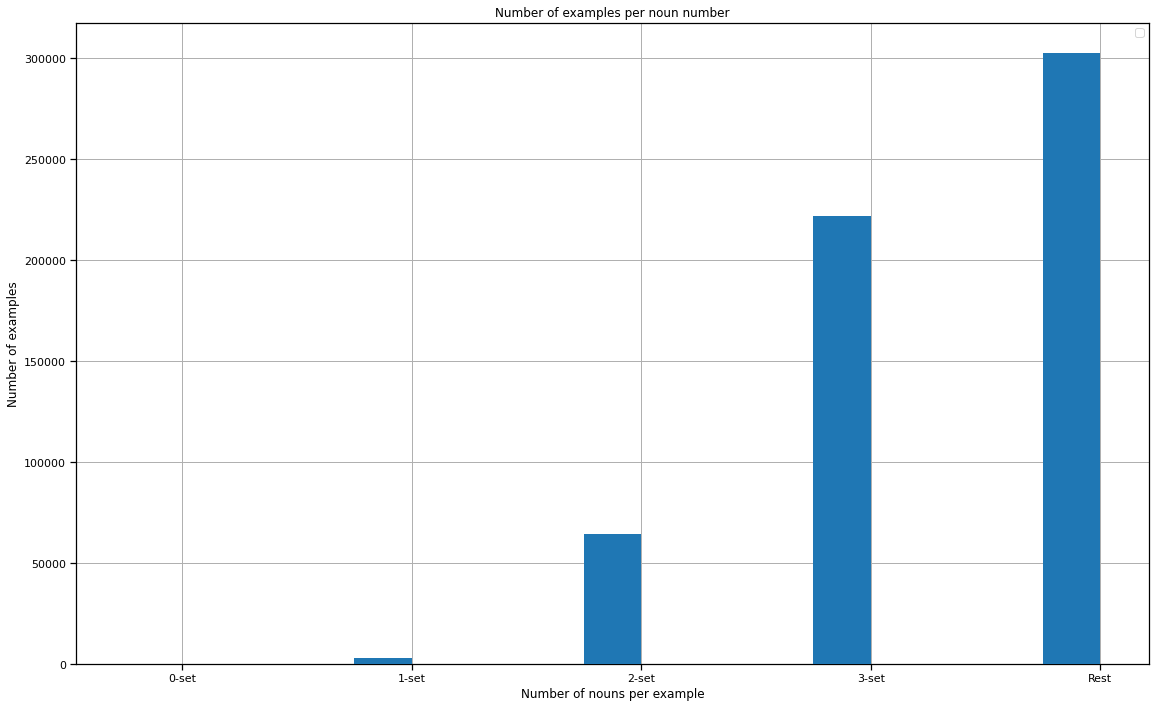

In [11]:
values=[]
for i in range(0,max_noun_no+1):
    values.append(ex_count_per_noun_no[i])
values.append(ex_count_per_noun_no['Rest'])

x_ticklabel = [str(i) + '-set' for i in list(np.arange(max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Number of examples', 
          'Number of examples per noun number')

No handles with labels found to put in legend.


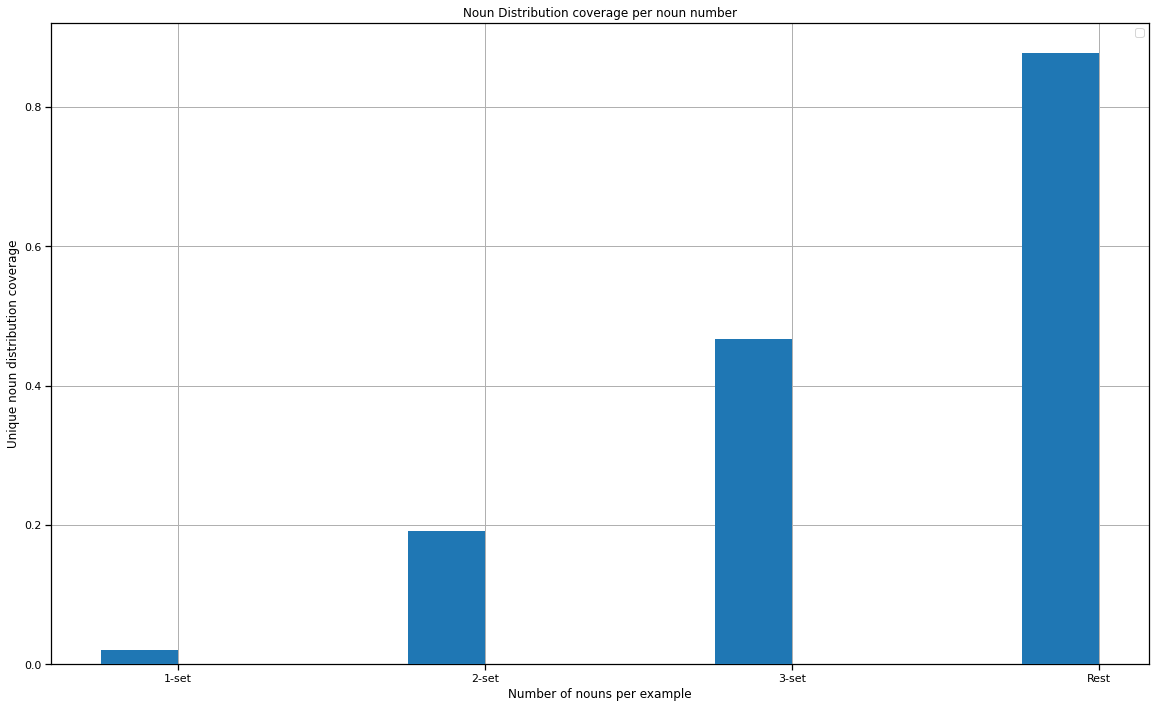

In [12]:
values=[]
for i in range(1,max_noun_no+1):
    values.append(len(noun_distr_per_noun_no[i])/len(net_unique_nouns))
values.append(len(noun_distr_per_noun_no['Rest'])/len(net_unique_nouns))

x_ticklabel = [str(i) + '-set' for i in list(np.arange(1, max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Unique noun distribution coverage', 
          'Noun Distribution coverage per noun number')

### Sets overlap statistics

In [17]:
coco_caps=COCO(ann_file)

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


In [18]:
caps_per_noun_no = {}

for i, img_cap_ids in enumerate(img_caps_list):
    _, cap_ids = zip(*img_cap_ids)
    caps_per_noun_no[i+1] = coco_caps.loadAnns(list(cap_ids))

In [19]:
prev_overlap_dict = {}

prev_uniq_noun_list=set()
for i in range(2, max_noun_no+2):
    prev_uniq_noun_list.update(set(noun_distr_per_noun_no[i-1]))
    prev_overlap = 0
    new_noun = 0
    for cap_dict in caps_per_noun_no[i]:
        cap = cap_dict['caption']
        noun_types_per_ex = set()
        
        found_overlap = 0
        for tok in nlp(cap):
            if 'NN' in tok.tag_ and word in prev_uniq_noun_list:
                found_overlap += 1
                if found_overlap == i-1:
                    prev_overlap += 1
                    break
                
        if found_overlap < i-1:
            new_noun += 1
        
    prev_overlap_dict[i] = (prev_overlap/len(caps_per_noun_no[i]), new_noun/len(caps_per_noun_no[i]))
    
for noun_no, overlap in prev_overlap_dict.items():
    print(noun_no, overlap)

2 (0.9752768276874542, 0.024723172312545876)
3 (0.9975262888856433, 0.0024737111143566526)
4 (0.9990910612270345, 0.0009089387729654701)


In [60]:
with open('../../data/coco/coco_stats/spacy/3_noun/noun_stats.pkl', 'wb') as f:
    pickle.dump([noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns], f)

no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)

del(no_nouns_list[0])
del(img_caps_list[0])
print(no_nouns_list)

with open('../../data/coco/coco_stats/spacy/3_noun/img_caps_per_noun_list.pkl', 'wb') as f:
    pickle.dump(img_caps_list, f)

[1, 2, 3, 'Rest']


### 3 Phases

In [32]:
# Counts number of examples for each noun 
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_tp_no_distr_stats(max_noun_no, tp):
    
    # noun_distr_per_noun_no = {}
    ex_count_per_noun_no = {}
    img_caps_per_noun_no = {}
    
    for i in range(1,max_noun_no+1):
        # noun_distr_per_noun_no[i] = {}
        ex_count_per_noun_no[i] = 0 
        img_caps_per_noun_no[i] = []
        
    # noun_distr_per_noun_no['Rest'] = {}
    ex_count_per_noun_no['Rest'] = 0 
    img_caps_per_noun_no['Rest'] = []
    ex_count_per_noun_no[0] = 0 
    img_caps_per_noun_no[0] = []
    
    net_unique_nouns = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in annotations:
        text = item['caption']
        noun_types_per_ex = set()
        
        for tok in nlp(text):
            if tp in tok.tag_:
                noun_types_per_ex.add(str(tok))
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        
        if no_noun_types_per_ex == 0:
            ex_count_per_noun_no[0] += 1
            img_caps_per_noun_no[0].append((item['image_id'], item['id']))
            continue
        
        elif no_noun_types_per_ex <= max_noun_no:
            # d_to_fill = noun_distr_per_noun_no[no_noun_types_per_ex]
            ex_count_per_noun_no[no_noun_types_per_ex] += 1
            img_caps_per_noun_no[no_noun_types_per_ex].append((item['image_id'], item['id']))
            
        else:
            # d_to_fill = noun_distr_per_noun_no['Rest']
            ex_count_per_noun_no['Rest'] += 1
            img_caps_per_noun_no['Rest'].append((item['image_id'], item['id']))
        
#         put_words_in_dict(d_to_fill, noun_types_per_ex)
#         net_unique_nouns.update(noun_types_per_ex)
                
    return ex_count_per_noun_no, img_caps_per_noun_no
#     return noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no

In [33]:
max_noun_no = 2
ex_count_per_noun_no, img_caps_per_noun_no = \
    per_tp_no_distr_stats(max_noun_no, 'NN')

In [34]:
len(img_caps_per_noun_no)

4

In [35]:
img_caps_per_noun_no.keys()

dict_keys([1, 2, 'Rest', 0])

In [36]:
img_caps_per_noun_no[1][:5]

[(183398, 500409),
 (488532, 323898),
 (157916, 705573),
 (439015, 498026),
 (159682, 308162)]

In [37]:
print('Total Examples with {} nouns per example: {}\n\n'.format(0, ex_count_per_noun_no[0]))

for i in range(1,max_noun_no+1):
    print('Total Examples with {} nouns per example: {}'.
          format(i, ex_count_per_noun_no[i]))
    
print('Total Examples with > {} nouns per example: {}'.format(max_noun_no, ex_count_per_noun_no['Rest']))

Total Examples with 0 nouns per example: 14


Total Examples with 1 nouns per example: 3023
Total Examples with 2 nouns per example: 63199
Total Examples with > 2 nouns per example: 525517


No handles with labels found to put in legend.


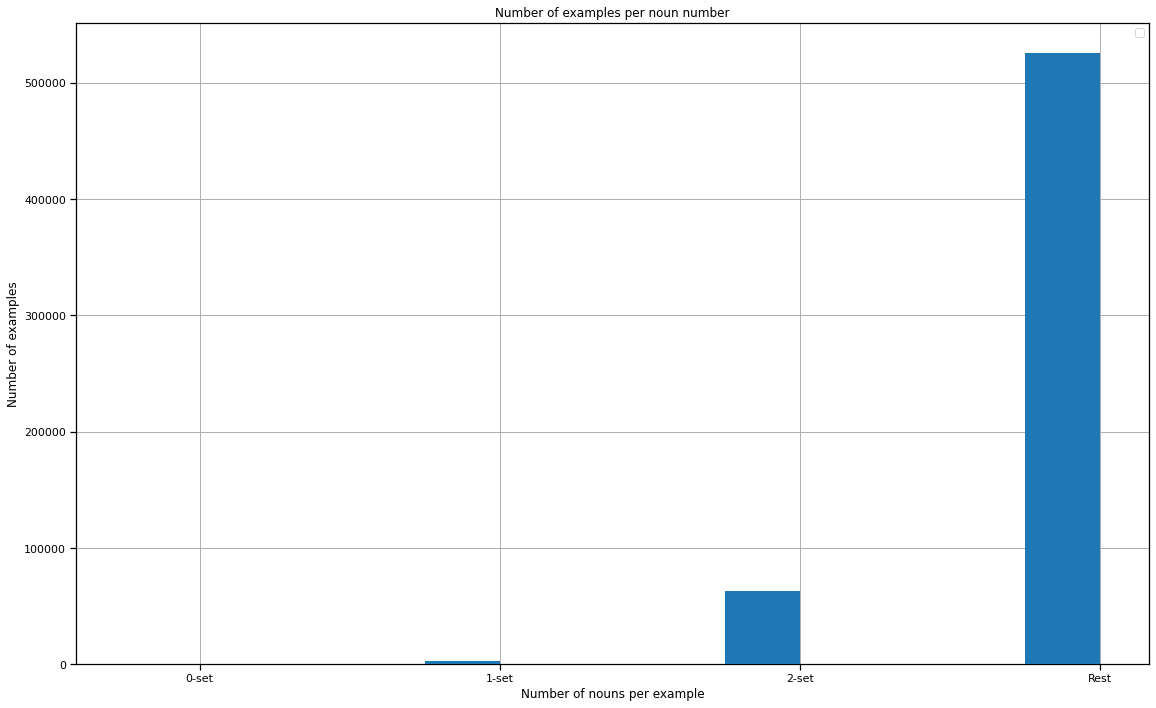

In [39]:
values=[]
for i in range(0,max_noun_no+1):
    values.append(ex_count_per_noun_no[i])
values.append(ex_count_per_noun_no['Rest'])

x_ticklabel = [str(i) + '-set' for i in list(np.arange(max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Number of examples', 
          'Number of examples per noun number')

In [43]:
with open('../../data/coco/coco_stats/spacy/2_noun/noun_stats.pkl', 'wb') as f:
    pickle.dump([ex_count_per_noun_no], f)

no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)

del(no_nouns_list[0])
del(img_caps_list[0])
print(no_nouns_list)

with open('../../data/coco/coco_stats/spacy/2_noun/img_caps_per_noun_list.pkl', 'wb') as f:
    pickle.dump(img_caps_list, f)

[1, 2, 'Rest']


### 5 Phases

In [32]:
# Counts number of examples for each noun 
# for those sentences having number of noun types each of {0,1,2,..max_noun_no,'Rest'}

def per_tp_no_distr_stats(max_noun_no, tp):
    
    # noun_distr_per_noun_no = {}
    ex_count_per_noun_no = {}
    img_caps_per_noun_no = {}
    
    for i in range(1,max_noun_no+1):
        # noun_distr_per_noun_no[i] = {}
        ex_count_per_noun_no[i] = 0 
        img_caps_per_noun_no[i] = []
        
    # noun_distr_per_noun_no['Rest'] = {}
    ex_count_per_noun_no['Rest'] = 0 
    img_caps_per_noun_no['Rest'] = []
    ex_count_per_noun_no[0] = 0 
    img_caps_per_noun_no[0] = []
    
    net_unique_nouns = set()
    
    def put_words_in_dict(d, ws):
        for w in ws:
            if w not in d:
                d[w] = 1
            else:
                d[w] += 1
    
    for item in annotations:
        text = item['caption']
        noun_types_per_ex = set()
        
        for tok in nlp(text):
            if tp in tok.tag_:
                noun_types_per_ex.add(str(tok))
                
        no_noun_types_per_ex = len(noun_types_per_ex)
        
        if no_noun_types_per_ex == 0:
            ex_count_per_noun_no[0] += 1
            img_caps_per_noun_no[0].append((item['image_id'], item['id']))
            continue
        
        elif no_noun_types_per_ex <= max_noun_no:
            # d_to_fill = noun_distr_per_noun_no[no_noun_types_per_ex]
            ex_count_per_noun_no[no_noun_types_per_ex] += 1
            img_caps_per_noun_no[no_noun_types_per_ex].append((item['image_id'], item['id']))
            
        else:
            # d_to_fill = noun_distr_per_noun_no['Rest']
            ex_count_per_noun_no['Rest'] += 1
            img_caps_per_noun_no['Rest'].append((item['image_id'], item['id']))
        
#         put_words_in_dict(d_to_fill, noun_types_per_ex)
#         net_unique_nouns.update(noun_types_per_ex)
                
    return ex_count_per_noun_no, img_caps_per_noun_no
#     return noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no

In [51]:
max_noun_no = 4
ex_count_per_noun_no, img_caps_per_noun_no = \
    per_tp_no_distr_stats(max_noun_no, 'NN')

KeyboardInterrupt: 

In [ ]:
len(img_caps_per_noun_no)

In [ ]:
img_caps_per_noun_no.keys()

In [ ]:
img_caps_per_noun_no[1][:5]

In [ ]:
print('Total Examples with {} nouns per example: {}\n\n'.format(0, ex_count_per_noun_no[0]))

for i in range(1,max_noun_no+1):
    print('Total Examples with {} nouns per example: {}'.
          format(i, ex_count_per_noun_no[i]))
    
print('Total Examples with > {} nouns per example: {}'.format(max_noun_no, ex_count_per_noun_no['Rest']))

In [ ]:
values=[]
for i in range(0,max_noun_no+1):
    values.append(ex_count_per_noun_no[i])
values.append(ex_count_per_noun_no['Rest'])

x_ticklabel = [str(i) + '-set' for i in list(np.arange(max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Number of examples', 
          'Number of examples per noun number')

In [ ]:
with open('../../data/coco/coco_stats/spacy/4_noun/noun_stats.pkl', 'wb') as f:
    pickle.dump([ex_count_per_noun_no], f)

no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)

del(no_nouns_list[0])
del(img_caps_list[0])
print(no_nouns_list)

with open('../../data/coco/coco_stats/spacy/4_noun/img_caps_per_noun_list.pkl', 'wb') as f:
    pickle.dump(img_caps_list, f)

### 6 Phases

In [13]:
max_noun_no = 3
noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns, img_caps_per_noun_no = \
    per_tp_no_distr_stats(max_noun_no, 'NN')

KeyboardInterrupt: 

In [ ]:
len(img_caps_per_noun_no)

In [ ]:
img_caps_per_noun_no.keys()

In [ ]:
img_caps_per_noun_no[1][:5]

In [ ]:
print('Total Examples with {} nouns per example: {}\n\n'.format(0, ex_count_per_noun_no[0]))

for i in range(1,max_noun_no+1):
    print('Total Examples with {} nouns per example: {}'.
          format(i, ex_count_per_noun_no[i]))
    print('Total Unique nouns with {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no[i])))
    
print('Total Examples with > {} nouns per example: {}'.format(max_noun_no, ex_count_per_noun_no['Rest']))
print('Total Unique nouns with > {} nouns per example: {}\n'.format(i, len(noun_distr_per_noun_no['Rest'])))

print('Total number of unique nouns: {}'.format(len(net_unique_nouns)))

In [ ]:
values=[]
for i in range(0,max_noun_no+1):
    values.append(ex_count_per_noun_no[i])
values.append(ex_count_per_noun_no['Rest'])

x_ticklabel = [str(i) + '-set' for i in list(np.arange(max_noun_no+1))] + ['Rest']

plot_bars(values, x_ticklabel, 'Number of nouns per example', 'Number of examples', 
          'Number of examples per noun number')

In [ ]:
with open('../../data/coco/coco_stats/spacy/5_noun/noun_stats.pkl', 'wb') as f:
    pickle.dump([noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns], f)

no_nouns_list, img_caps_list = zip(*(sorted(img_caps_per_noun_no.items(), key=lambda l: l[0] if type(l[0])==int else 99999)))
no_nouns_list, img_caps_list = list(no_nouns_list), list(img_caps_list)

del(no_nouns_list[0])
del(img_caps_list[0])
print(no_nouns_list)

with open('../../data/coco/coco_stats/spacy/5_noun/img_caps_per_noun_list.pkl', 'wb') as f:
    pickle.dump(img_caps_list, f)

In [49]:
n1.keys()

dict_keys([1, 2, 3, 4, 5, 'Rest'])

In [50]:
n2.keys()

dict_keys([1, 2, 3, 4, 5, 'Rest', 0])

In [53]:
n2.values()

dict_values([3158, 64382, 221819, 193701, 76885, 31794, 14])

### New Noun Investigation

In [7]:
from collections import defaultdict

In [8]:
with open('../../data/coco/coco_stats/spacy/3_noun/noun_stats.pkl', 'rb') as f:
    noun_distr_per_noun_no, ex_count_per_noun_no, net_unique_nouns = pickle.load(f)

with open('../../data/coco/coco_stats/spacy/3_noun/img_caps_per_noun_list.pkl', 'rb') as f:
    img_caps_list = pickle.load(f)

In [10]:
ann_file = '../datasets/coco/annotations/captions_train2017.json'
coco_caps=COCO(ann_file)

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!


In [13]:
caps_per_noun_no = {}

for i, img_cap_ids in enumerate(img_caps_list):
    _, cap_ids = zip(*img_cap_ids)
    caps_per_noun_no[i+1] = coco_caps.loadAnns(list(cap_ids))

In [16]:
prev_uniq_noun_list=set()
for i in range(2, max_noun_no+2):
    prev_uniq_noun_list.update(set(noun_distr_per_noun_no[i-1]))
    prev_overlap_dict = defaultdict(int)
    for cap_dict in caps_per_noun_no[i]:
        cap = cap_dict['caption']
        noun_types_per_ex = set()
        
        found_overlap = 0
        for word in cap.split():
            if word in prev_uniq_noun_list:
                found_overlap += 1
                
        prev_overlap_dict[found_overlap] += 1
    
    for k in prev_overlap_dict.keys():
        prev_overlap_dict[k] /= len(caps_per_noun_no[i])
        
    print(i)
    print(prev_overlap_dict)
    print('\n')

2
defaultdict(<class 'int'>, {1: 0.5804883352489827, 0: 0.07146407380944984, 2: 0.3163461837159455, 3: 0.029464757230281757, 4: 0.002003665620825697, 5: 0.00021745208288030817, 6: 1.5532291634307727e-05})


3
defaultdict(<class 'int'>, {3: 0.39479034708478533, 2: 0.20958078433317254, 1: 0.015305271414982486, 4: 0.2591211753727138, 5: 0.09483858461177808, 7: 0.003759822197377141, 6: 0.021152380995316, 0: 0.0007708987958650972, 8: 0.0005364734310406232, 9: 0.00010368814213390197, 10: 4.0573620835005115e-05})


4
defaultdict(<class 'int'>, {5: 0.2958231364508235, 6: 0.2515774852834182, 4: 0.17828560089953038, 7: 0.13082545141874463, 3: 0.04700377009061446, 8: 0.05131953171506052, 2: 0.007930418678484027, 10: 0.00843309742707851, 9: 0.019998015741781863, 11: 0.003502215755010252, 1: 0.0012600039685164363, 12: 0.0018089820755340961, 13: 0.000945829750644884, 16: 0.00014220517229975529, 15: 0.0003009458297506449, 17: 0.00015543356042066274, 14: 0.00046299358423176136, 0: 4.299226139294927e-0

In [14]:
prev_overlap_dict = {}
max_noun_no = 3

prev_uniq_noun_list=set()
for i in range(2, max_noun_no+2):
    prev_uniq_noun_list.update(set(noun_distr_per_noun_no[i-1]))
    prev_overlap = 0
    new_noun = 0
    for cap_dict in caps_per_noun_no[i]:
        cap = cap_dict['caption']
        noun_types_per_ex = set()
        
        found_overlap = 0
        for word in cap.split():
            if word in prev_uniq_noun_list:
                found_overlap += 1
                if found_overlap == i-1:
                    prev_overlap += 1
                    break
                
        if found_overlap < i-1:
            new_noun += 1
        
    prev_overlap_dict[i] = (prev_overlap/len(caps_per_noun_no[i]), new_noun/len(caps_per_noun_no[i]))
    
for noun_no, overlap in prev_overlap_dict.items():
    print(noun_no, overlap)

2 (0.9285359261905501, 0.07146407380944984)
3 (0.9839238297891524, 0.016076170210847583)
4 (0.9907665850916065, 0.009233414908393413)
